# Fake News Model

In this notebook, a machine learning model to classify fake news articles is trained. Various embedding techniques, such as TF-IDF, Word2Vec, BERT, Bag-of-Words (BoW), and MiniLM, are explored as features to represent the textual data. The goal is to evaluate the effectiveness of these embeddings in detecting fake news and to identify the best-performing feature set for the classification task.

In [2]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


Restart before running this cell

In [17]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import pickle
import ast
import json
import joblib
import copy

# Machine learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import torch
import spacy

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [2]:
# Function to load the dataset with the embeddings
def load_dataframes_from_folder(folder_path, startswith, endswith, key_position):

    dataframes_dict = {}

    # Loop through files in the folder
    for filename in os.listdir(folder_path):
        if filename.startswith(startswith) and filename.endswith(endswith):

            # Extract the key symbol
            ticker = filename.split('_')[ key_position]

            # Read the CSV file into a dataframe
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            # Add the dataframe to the dictionary
            dataframes_dict[ticker] = df

    return dataframes_dict

In [3]:
# Data path
folder_path = '/content/drive/MyDrive/Dataset'

In [4]:
# Create output folder for models if don't exist

# Full path to the 'models' subfolder
models_path = os.path.join(folder_path, 'models')

# Create the folder if it doesn't exist
os.makedirs(models_path, exist_ok=True)

In [5]:
# Loading fake news DataFrame
fake_news_dict_emb = load_dataframes_from_folder(folder_path, startswith = 'fake_news', endswith='_embedings.csv' , key_position = 2)

In [6]:
# Having a look to the data
fake_news_dict_emb['training'].head(1)

,fake_news,title,text_column_tokens,text_without_puntutation,lemmatizers,without_stop_words,text_column,compound_score,positive_score,neutral_score,negative_score,roberta_neg,roberta_neu,roberta_pos,roberta_sentiment,joy,anger,fear,sadness,disgust,surprise,neutral,sentiment_label,sentiment_score,tfidf_embedding,tfidf_length,word2vec_embedding,word2vec_length,bert_embedding,bert_length,bow_embedding,bow_length,miniLM_embedding,miniLM_shape
0,0,donald trump sends out embarrassing new year‚s...,"['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'embarrass', 'new...",donald trump sends embarrass new eve message d...,-0.5994,0.0,0.55,0.45,0.77113,0.218655,0.010215,0,0.002908,0.088452,0.109574,0.088292,0.12651,0.109849,0.474416,LABEL_0,0.971903,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13835,"[0.07877926528453827, 0.18123498558998108, 0.3...",100,"[-0.2652573883533478, 0.2408067286014557, 0.16...",768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,"[0.045953016728162766, 0.08347233384847641, 0....",384


In [7]:
fake_news_dict_emb['training']['tfidf_embedding'][1]

'[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [8]:
fake_news_dict_emb['training']['word2vec_embedding'][1]

'[0.01792094297707081, 0.14101122319698334, 0.3107313811779022, 0.10020030289888382, -0.3185173273086548, -0.6084880828857422, 0.19966313242912292, 0.7664806246757507, -0.07693791389465332, -0.10303635150194168, -0.03444590047001839, -0.5987389087677002, -0.20646247267723083, 0.25874778628349304, -0.030866649001836777, -0.2016924023628235, -0.08833763003349304, -0.17901410162448883, 0.04513474926352501, -0.4101986289024353, 0.299313485622406, 0.17645440995693207, 0.25956594944000244, -0.2513704299926758, 0.20083552598953247, 0.2424388825893402, 0.09360664337873459, -0.11266879737377167, -0.4445352256298065, -0.07098398357629776, 0.23502129316329956, 0.16167737543582916, 0.518446147441864, -0.20875445008277893, 0.05705542862415314, 0.1944301873445511, 0.25471192598342896, -0.4337197244167328, -0.2800884544849396, -0.43836766481399536, -0.21595153212547302, -0.3178400695323944, -0.2068043053150177, 0.021420398727059364, 0.4137752056121826, -0.05560167133808136, -0.35153940320014954, 0.18

In [9]:
fake_news_dict_emb['training']['bert_embedding'][1]

'[-0.3747653663158417, -0.162393257021904, -0.14209264516830444, -0.10818260908126831, -0.3267061412334442, -0.1671573370695114, 0.44252336025238037, 0.5175206065177917, -0.14453953504562378, -0.033239174634218216, 0.06723059713840485, -0.8079968094825745, -0.35116246342658997, 0.24124325811862946, -0.35643771290779114, -0.3956555426120758, -0.18022224307060242, 0.48595693707466125, 0.4159564971923828, -0.18786969780921936, 0.5371562838554382, -0.6683969497680664, -0.12947450578212738, -0.5038519501686096, 0.08858894556760788, -0.3809218406677246, -0.21775349974632263, 0.10984155535697937, -0.2898615598678589, 0.12887859344482422, -0.15406881272792816, -0.09026868641376495, -0.025465218350291252, 0.17642933130264282, -0.1203102096915245, -0.2085038423538208, 0.3376784920692444, 0.1752716302871704, -0.08744484186172485, 0.03448677808046341, -0.02984767220914364, -0.15749481320381165, -0.14665143191814423, 0.12378348410129547, 0.19015491008758545, -0.21030905842781067, -2.388302564620971

In [10]:
fake_news_dict_emb['training']['bow_embedding'][1]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
fake_news_dict_emb['training']['miniLM_embedding'][1]

'[-0.06502026319503784, -0.015925128012895584, -0.0062947035767138, 0.03828735649585724, 0.03668144717812538, -0.05987704545259476, 0.012344669550657272, 0.0012025516480207443, 0.059576183557510376, -0.04246574640274048, -0.045896098017692566, 0.0410340242087841, -0.01661628857254982, 0.1346527487039566, -0.10671696066856384, -0.051922474056482315, -0.04154796898365021, -0.018466463312506676, -0.005356379318982363, -0.040125783532857895, -0.0033009261824190617, -0.07791132479906082, 0.0756281390786171, -0.04249861463904381, 0.03268527239561081, 0.048279061913490295, 0.025336844846606255, -0.005633190274238586, -0.01165353786200285, 0.0004180659307166934, 0.0708264410495758, 0.016578562557697296, 0.019987907260656357, 0.028057420626282692, -0.019190723076462746, -0.016674280166625977, 0.041677575558423996, 0.023034511134028435, 0.1662670075893402, 0.0748772993683815, 0.029743297025561333, -0.14365403354167938, 0.02875099889934063, 0.0357842892408371, -0.04704425856471062, 0.058735501021

In [7]:
# A copy for good practices
df2 = fake_news_dict_emb['training'].copy()

In [13]:
df2.dtypes

,0
fake_news,int64
title,object
text_column_tokens,object
text_without_puntutation,object
lemmatizers,object
without_stop_words,object
text_column,object
compound_score,float64
positive_score,float64
neutral_score,float64


In [8]:
# Transforming the embedings columns to list

embedding_columns = [
    'bow_embedding',
    'tfidf_embedding',
    'word2vec_embedding',
    'bert_embedding',
    'miniLM_embedding'
]

for col in embedding_columns:
    df2[col] = df2[col].apply(json.loads)

In [15]:
df2.head(2)

,fake_news,title,text_column_tokens,text_without_puntutation,lemmatizers,without_stop_words,text_column,compound_score,positive_score,neutral_score,negative_score,roberta_neg,roberta_neu,roberta_pos,roberta_sentiment,joy,anger,fear,sadness,disgust,surprise,neutral,sentiment_label,sentiment_score,tfidf_embedding,tfidf_length,word2vec_embedding,word2vec_length,bert_embedding,bert_length,bow_embedding,bow_length,miniLM_embedding,miniLM_shape
0,0,donald trump sends out embarrassing new year‚s...,"['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'embarrass', 'new...",donald trump sends embarrass new eve message d...,-0.5994,0.0,0.550,0.450,0.771130,0.218655,0.010215,0,0.002908,0.088452,0.109574,0.088292,0.126510,0.109849,0.474416,LABEL_0,0.971903,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13835,"[0.07877926528453827, 0.18123498558998108, 0.3...",100,"[-0.2652573883533478, 0.2408067286014557, 0.16...",768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,"[0.045953016728162766, 0.08347233384847641, 0....",384
1,0,drunk bragging trump staffer started russian c...,"['drunk', 'bragging', 'trump', 'staffer', 'sta...","['drunk', 'bragging', 'trump', 'staffer', 'sta...","['drunk', 'bragging', 'trump', 'staffer', 'sta...","['drunk', 'bragging', 'trump', 'staffer', 'sta...",drunk bragging trump staffer start russian col...,-0.3400,0.0,0.745,0.255,0.514261,0.467208,0.018531,0,0.010220,0.437211,0.237583,0.022953,0.014639,0.015434,0.261959,LABEL_0,0.493148,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13835,"[0.01792094297707081, 0.14101122319698334, 0.3...",100,"[-0.3747653663158417, -0.162393257021904, -0.1...",768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,"[-0.06502026319503784, -0.015925128012895584, ...",384


In [17]:
df2.dtypes

,0
fake_news,int64
title,object
text_column_tokens,object
text_without_puntutation,object
lemmatizers,object
without_stop_words,object
text_column,object
compound_score,float64
positive_score,float64
neutral_score,float64


In [19]:
!pip install lazypredict

In [18]:
from lazypredict.Supervised import LazyClassifier

In [9]:
def convert_sentiment_labels(df):

    if 'sentiment_label' in df.columns:
        df['sentiment_label'] = df['sentiment_label'].apply(lambda x: int(x.split('_')[1]))
    return df

In [10]:
df2 = convert_sentiment_labels(df2)

In [21]:
df2.head(2)

,fake_news,title,text_column_tokens,text_without_puntutation,lemmatizers,without_stop_words,text_column,compound_score,positive_score,neutral_score,negative_score,roberta_neg,roberta_neu,roberta_pos,roberta_sentiment,joy,anger,fear,sadness,disgust,surprise,neutral,sentiment_label,sentiment_score,tfidf_embedding,tfidf_length,word2vec_embedding,word2vec_length,bert_embedding,bert_length,bow_embedding,bow_length,miniLM_embedding,miniLM_shape
0,0,donald trump sends out embarrassing new year‚s...,"['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'out', 'embarrass...","['donald', 'trump', 'sends', 'embarrass', 'new...",donald trump sends embarrass new eve message d...,-0.60,0.00,0.55,0.45,0.77,0.22,0.01,0,0.00,0.09,0.11,0.09,0.13,0.11,0.47,0,0.97,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13835,"[0.07877926528453827, 0.18123498558998108, 0.3...",100,"[-0.2652573883533478, 0.2408067286014557, 0.16...",768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,"[0.045953016728162766, 0.08347233384847641, 0....",384
1,0,drunk bragging trump staffer started russian c...,"['drunk', 'bragging', 'trump', 'staffer', 'sta...","['drunk', 'bragging', 'trump', 'staffer', 'sta...","['drunk', 'bragging', 'trump', 'staffer', 'sta...","['drunk', 'bragging', 'trump', 'staffer', 'sta...",drunk bragging trump staffer start russian col...,-0.34,0.00,0.74,0.26,0.51,0.47,0.02,0,0.01,0.44,0.24,0.02,0.01,0.02,0.26,0,0.49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13835,"[0.01792094297707081, 0.14101122319698334, 0.3...",100,"[-0.3747653663158417, -0.162393257021904, -0.1...",768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,"[-0.06502026319503784, -0.015925128012895584, ...",384


In [11]:
def flatten_vector_column(df, column):
    """Expands a list column into multiple columns."""
    vecs = df[column].apply(lambda x: np.array(x) if isinstance(x, list) else np.zeros(1))
    expanded = pd.DataFrame(vecs.tolist(), index=df.index)
    expanded.columns = [f"{column}_{i}" for i in range(expanded.shape[1])]
    return expanded


In [12]:
def run_lazy_classification(X, y, feature_desc=""):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    print(f"\n📊 Results for: {feature_desc}")
    print(models.head(3))
    return models

In [13]:
def evaluate_feature_combinations(df, vector_columns, scalar_columns, target_column='fake_news'):
    y = df[target_column]
    all_results = {}

    for vector_col in vector_columns:
        # 1️⃣ Vector column alone
        print(f"\n🚀 Testing only vector: {vector_col}")
        X_vec = flatten_vector_column(df, vector_col)
        result_vec_only = run_lazy_classification(X_vec, y, feature_desc=f"{vector_col} only")
        all_results[f"{vector_col}_only"] = result_vec_only

        # 2️⃣ Vector + all scalar columns
        print(f"\n🔗 Testing {vector_col} + scalar columns: {scalar_columns}")
        X_scalars = df[scalar_columns].copy()
        X_combined = pd.concat([X_vec, X_scalars], axis=1)
        result_combined = run_lazy_classification(X_combined, y, feature_desc=f"{vector_col} + scalars")
        all_results[f"{vector_col}_plus_scalars"] = result_combined

    return all_results

In [14]:
vector_columns = ['word2vec_embedding', 'bert_embedding', 'bow_embedding', 'miniLM_embedding']
scalar_columns = ['joy', 'anger', 'fear', 'sadness', 'disgust', 'surprise', 'neutral', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'roberta_sentiment']
target = 'fake_news'

In [26]:
results = evaluate_feature_combinations(df2, vector_columns, scalar_columns)


🚀 Testing only vector: word2vec_embedding


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: word2vec_embedding only
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.83               0.83     0.83      0.83   
LinearSVC                   0.83               0.83     0.83      0.83   
CalibratedClassifierCV      0.83               0.83     0.83      0.83   

                        Time Taken  
Model                               
SVC                  

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28054
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: word2vec_embedding + scalars
               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  Time Taken
Model                                                                    
XGBClassifier      0.86               0.86     0.86      0.86        1.67
SVC                0.86               0.86     0.86      0.86       41.42
LinearSVC          0.85               0.86     0.86      0.85        3.31

🚀 Testing only vector: bert_embedding


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: bert_embedding only
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.96               0.96     0.96      0.96   
LogisticRegression          0.95               0.95     0.95      0.95   
CalibratedClassifierCV      0.95               0.95     0.95      0.95   

                        Time Taken  
Model                               
SVC                     

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198394
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 779
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: bert_embedding + scalars
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.96               0.96     0.96      0.96   
CalibratedClassifierCV      0.96               0.96     0.96      0.96   
LinearSVC                   0.96               0.96     0.96      0.96   

                        Time Taken  
Model                               
SVC                

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3389
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: bow_embedding only
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.91               0.91     0.91      0.91   
LogisticRegression          0.91               0.91     0.91      0.91   
CalibratedClassifierCV      0.91               0.91     0.91      0.91   

                        Time Taken  

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5943
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 1011
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: bow_embedding + scalars
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.91               0.91     0.91      0.91   
CalibratedClassifierCV      0.91               0.91     0.91      0.91   
LinearSVC                   0.91               0.91     0.91      0.91   

                        Time Taken  
Model                               
SVC                  

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: miniLM_embedding only
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.95               0.95     0.95      0.95   
CalibratedClassifierCV      0.94               0.94     0.94      0.94   
LinearSVC                   0.94               0.94     0.94      0.94   

                        Time Taken  
Model                               
SVC                    

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 12979, number of negative: 12782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100474
[LightGBM] [Info] Number of data points in the train set: 25761, number of used features: 395
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503824 -> initscore=0.015295
[LightGBM] [Info] Start training from score 0.015295

📊 Results for: miniLM_embedding + scalars
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
SVC                         0.95               0.95     0.95      0.95   
LinearSVC                   0.94               0.94     0.94      0.94   
CalibratedClassifierCV      0.94               0.94     0.94      0.94   

                        Time Taken  
Model                               
SVC              

In [18]:
# Function to perform GridSearchCV for different models
def perform_grid_search(X_train, y_train, models, param_grids):
    best_models = {}
    best_scores = {}

    for model_name, model in models:
        print(f"Starting GridSearchCV for {model_name}...")

        # Perform GridSearchCV
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Save the best model and score
        best_models[model_name] = grid_search.best_estimator_
        best_scores[model_name] = grid_search.best_score_

        print(f"Best Params for {model_name}: {grid_search.best_params_}")
        print(f"Best Score for {model_name}: {grid_search.best_score_}")

    return best_models, best_scores

In [16]:
# Train test split, using only the bert_embedding
y = df2['fake_news']
X = flatten_vector_column(df2, 'bert_embedding')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
# Grid Search for LogisticRegression

models = [
    ('LogisticRegression', LogisticRegression())
]

param_grids = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
}

# Perform grid search on the models
best_models, best_scores = perform_grid_search(X_train, y_train, models, param_grids)

# Evaluate the best models on the test set
for model_name, model in best_models.items():
    print(f"Evaluating best model {model_name}...")
    y_pred = model.predict(X_test)
    print(f"{model_name} Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")

Starting GridSearchCV for LogisticRegression...
Best Params for LogisticRegression: {'C': 0.1, 'solver': 'saga'}
Best Score for LogisticRegression: 0.9526804321911013
Evaluating best model LogisticRegression...
LogisticRegression Accuracy on Test Set: 0.9556


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
# Fitting SVC model

model_svc = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
model_svc.fit(X_train, y_train)

SVC(C=1, probability=True, random_state=42)

In [24]:
# Evaluating SVC model

y_pred = model_svc.predict(X_test)
print(f"SVC Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")

SVC Accuracy on Test Set: 0.9627


In [25]:
# Saving the best model and scaler
joblib.dump(model_svc, os.path.join(models_path, 'svc_model'))
joblib.dump(scaler, os.path.join(models_path, 'scaler'))

['/content/drive/MyDrive/Dataset/models/scaler']

In [26]:
# Loading model during development

best_model = joblib.load(os.path.join(models_path, 'svc_model'))
scaler = joblib.load(os.path.join(models_path, 'scaler'))

In [27]:
# Predictions

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

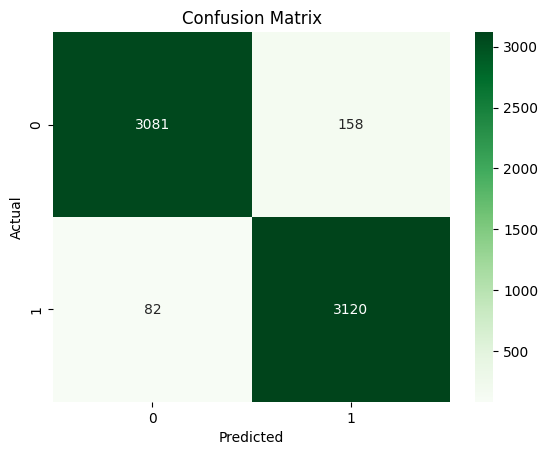

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(models_path, "confusion_matrix.png"),
                    bbox_inches='tight',
                    facecolor='none',
                    transparent=True)
plt.show()

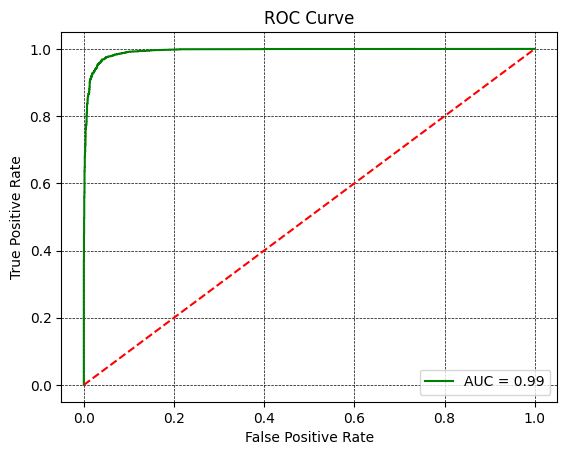

In [29]:
# Plot the ROC curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color = 'green')
plt.plot([0, 1], [0, 1], linestyle='--', color = 'red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.savefig(os.path.join(models_path, f"roc.png"),
                bbox_inches='tight',
                facecolor='none',
                transparent=True)

plt.show()

In [30]:
# Model metrics

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="binary")
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Model Metrics: | Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1-score = {round(f1, 4)} |")
print(f"Confusion Matrix: \n{conf_matrix}\n")


Model Metrics: | Accuracy = 0.9627 | Precision = 0.9518 | Recall = 0.9744 | F1-score = 0.963 |
Confusion Matrix: 
[[3081  158]
 [  82 3120]]



In [32]:
# Model cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []
training_scores = []
test_scores = []
average = {}

fold = 1
for train_index, test_index in kf.split(X):

    print('fold:', fold)
    # Splitting the data into training and testing sets for the fold
    X_traink, X_testk = X.iloc[train_index], X.iloc[test_index]
    y_traink, y_testk = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the model
    model_tree = copy.deepcopy(best_model)
    model_tree.fit(X_traink, y_traink)

    # Predict on the training and testing sets
    y_train_predk = model_tree.predict(X_traink)
    y_test_predk = model_tree.predict(X_testk)

    # Calculate accuracy scores for training and testing
    train_accuracyk = accuracy_score(y_traink, y_train_predk)
    test_accuracyk = accuracy_score(y_testk, y_test_predk)

    # F1-Score for a more robust metric in classification
    train_f1k = f1_score(y_traink, y_train_predk, average='weighted')
    test_f1k = f1_score(y_testk, y_test_predk, average='weighted')

    training_scores.append(train_accuracyk)
    test_scores.append(test_accuracyk)

    # Save fold results to print and return later
    results.append({
            'Fold': fold,
            'Train Accuracy': round(train_accuracyk, 4),
            'Test Accuracy': round(test_accuracyk, 4),
            'Train F1': round(train_f1k, 4),
            'Test F1': round(test_f1k, 4)
        })

    fold += 1

# Create a DataFrame to return the results of the cross-validation
results_df = pd.DataFrame(results)

# Calculate average scores across all folds
avg_train_accuracy = round(sum(training_scores) / len(training_scores), 4)
avg_test_accuracy = round(sum(test_scores) / len(test_scores), 4)

# Append the results for this n_splits to the overall results
average = {
            'n_splits': 5,
            'Average Train Accuracy': avg_train_accuracy,
            'Average Test Accuracy': avg_test_accuracy
        }

# Print conclusion based on the accuracy scores
print("Cross-Validation Results:")
print(f"Number of folds: {5}")
print("Average Training Accuracy: ", avg_train_accuracy)
print("Average Test Accuracy: ", avg_test_accuracy)


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
Cross-Validation Results:
Number of folds: 5
Average Training Accuracy:  0.9629
Average Test Accuracy:  0.9548


In [33]:
# Submition dataset
df4 = fake_news_dict_emb['testing'].copy()

In [34]:
# Transforming bert_embeddings
df4['bert_embedding'] = df4['bert_embedding'].apply(json.loads)

In [35]:
# Scaling X
Xt = flatten_vector_column(df4, 'bert_embedding')
X_scaledt = scaler.fit_transform(Xt)

In [36]:
# Predictions
y_pred = best_model.predict(X_scaledt)

In [37]:
def fake_news_distribution(y_pred, word = 'testing'):
    """
    Plots the distribution of fake news articles in the dataset.

    Args:
        dataframe (pd.DataFrame): DataFrame containing the news articles with a 'fake_news' column.
    """
    # Count the number of fake and real articles
    unique_values, frequencies = np.unique(y_pred, return_counts=True)

    # Create a bar plot for the distribution of fake vs real articles
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique_values, y=frequencies, palette='rocket', hue = unique_values)

    for i, v in enumerate(frequencies):
        plt.text(i, v +100, f'{v}', ha='center', fontsize=12)

    plt.ylim(0, 5300)

    # Set labels and title
    plt.xlabel('Fake News (0 = Not Fake, 1 = Fake)', fontsize=12)
    plt.ylabel('Number of Articles', fontsize=12)
    plt.title('Distribution of Fake News Articles in Testing Datsaet', fontsize=16)
    plt.legend().set_visible(False)

    # Show the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(os.path.join(folder_path, f"Distribution_of_Fake_News_Articles_{word}.png"),
                bbox_inches='tight',
                facecolor='none',
                transparent=True)
    plt.tight_layout()
    plt.show()

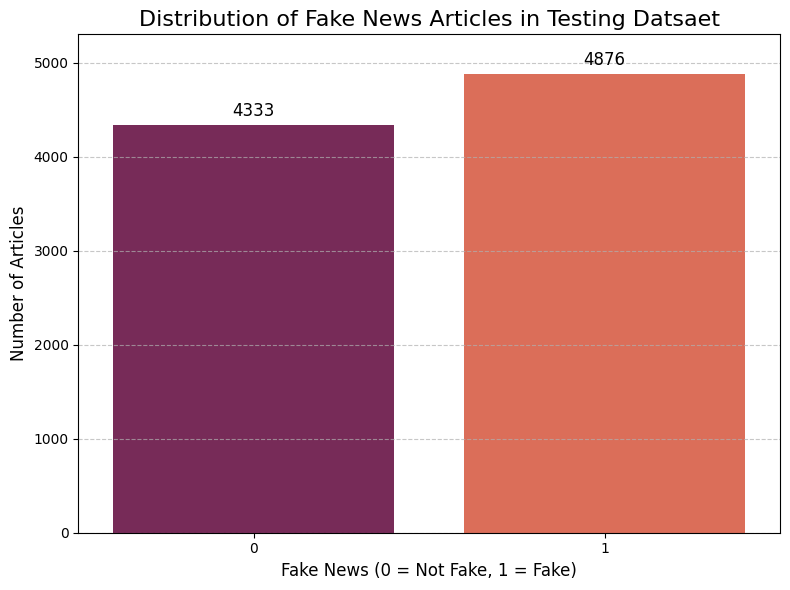

In [38]:
fake_news_distribution(y_pred)

In [39]:
def fake_news_distribution_frequencie(y_pred, word = 'testing'):
    """
    Plots the distribution of fake news articles in the dataset.

    Args:
        dataframe (pd.DataFrame): DataFrame containing the news articles with a 'fake_news' column.
    """
    # Count the number of fake and real articles
    unique_values, frequencies = np.unique(y_pred, return_counts=True)
    total_count = len(y_pred)
    relative_frequencies = frequencies / total_count

    # Create a bar plot for the distribution of fake vs real articles
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique_values, y=relative_frequencies, palette='rocket', hue = unique_values)

    for i, v in enumerate(relative_frequencies):
        plt.text(i, v + 0.01, f'{v*100:.1f}%', ha='center', fontsize=12)

    plt.ylim(0, 0.6)

    # Set labels and title
    plt.xlabel('Fake News (0 = Not Fake, 1 = Fake)', fontsize=12)
    plt.ylabel('Number of Articles', fontsize=12)
    plt.title('Relative Distribution of Fake News Articles in Testing Datsaet', fontsize=16)
    plt.legend().set_visible(False)

    # Show the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the figure
    plt.savefig(os.path.join(folder_path, f"Distribution_of_Fake_News_Articles_{word}_relative.png"),
                bbox_inches='tight',
                facecolor='none',
                transparent=True)
    plt.tight_layout()
    plt.show()

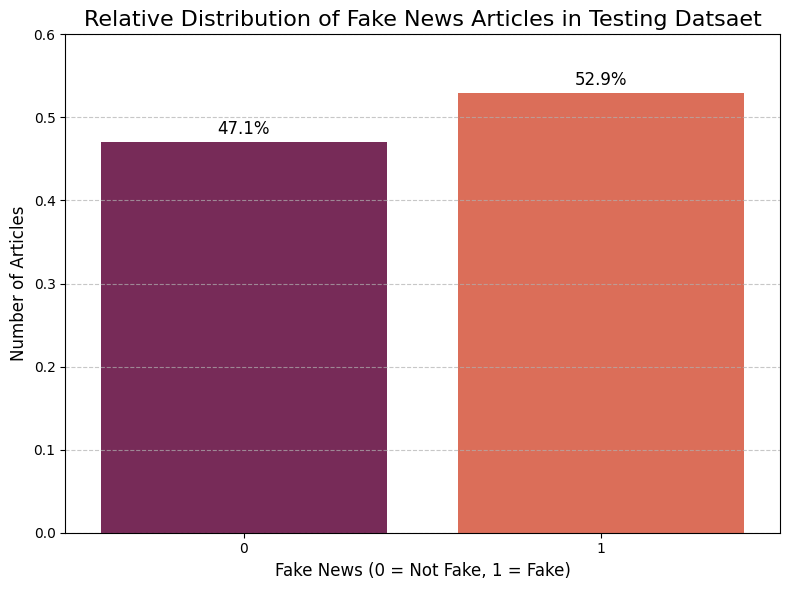

In [40]:
fake_news_distribution_frequencie(y_pred)